In [1]:
import numpy as np
from sklearn.utils import shuffle
import pickle

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from plots import knn_classifier_plot
from matplotlib.colors import ListedColormap
import seaborn as sns
from plots import plot_classifier

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification

In [5]:
# multiple class svm (not finished)
class SVClassifier:
    """Support Vector Classifier"""
    def __init__(self, C=1000, max_iter=1000, tol=0.0001, learning_rate=0.001,
                gradient_type="batch"):
        self.C = C
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.gradient_type = gradient_type
        self.multiclass = False
        self.svms = None
        self.w = None
        self.costs = []
    
    def calculate_cost(self, X, y):
        """calculate hinge loss"""
        dists = 1 - y * np.dot(X, self.w)
        # max(0, dist)
        dists[dists < 0] = 0
        loss = self.C * (np.sum(dists) / X.shape[0])

        # calculate cost
        cost = .5 * np.dot(self.w, self.w) + loss
        
        return cost
    
    def calculate_cost_gradient(self, X_sample, y_sample):
        """calculate gradient of cost function

        Parameters
        ----------
        X_sample: sample of features
            (sample_size, n_features + 1)
        y_sample: sample of outputs
            (sample_size)

        Returns
        -------
        dw: derivatives of weights (gradient)
            (n_features + 1)
        """
        # if sample has one point
        if not isinstance(y_sample, np.ndarray):
            y_sample = np.array([y_sample])
            X_sample = np.array([X_sample])
            
        # calculate distances of points to hyperplane
        dists = 1 - (y_sample * np.dot(X_sample, self.w))
        dw = np.zeros(len(self.w))

        # calculate gradient
        for i in range(len(dists)):
            if max(0, dists[i]) == 0:
                di = self.w
            else:
                di = self.w - (self.C * y_sample[i] * X_sample[i])
            dw += di

        dw = dw / len(y_sample)
        
        return dw 
    
    def fit(self, X_train, y_train):
        """fits train data

        Parameters
        ----------
        X_train: features data
            (n_sample, n_features)
        y_train: outputs data
            (n_sample)"""
        # multiple class or not
        self.labels = list(np.unique(y_train))
        if len(self.labels) > 2:
            self.multiclass = True
            return self.multiclass_fit(X_train, y_train)
        else:
            self.multiclass = False
        
        # prepare data
        X = self._add_intercept(X_train)
        y = y_train.copy()

        prev_cost = float("inf")
        #max_feature = np.max(X)
        self.w = np.ones(X.shape[1])
        self.costs = []

        for epoch in range(1, self.max_iter):
            # batch gradient
            if self.gradient_type == "batch":
                # update weights
                ascent = self.calculate_cost_gradient(X, y)
                self.w = self.w - (self.learning_rate * ascent)
                cost = self.calculate_cost(X, y)
                #print("Epoch: {}, Cost: {}".format(epoch, cost))
            elif self.gradient_type == "stochastic":
                # shuffle X and y
                X, y = shuffle(X, y)
                sum_cost = 0
                
                for i in range(len(X)):
                    ascent = self.calculate_cost_gradient(X[i], y[i])
                    self.w = self.w - (self.learning_rate * ascent)
                    cost = self.calculate_cost(X, y)
                    sum_cost += cost
                cost = sum_cost / len(X)

            # stop
#             if np.mean(np.abs(ascent[1:])) < self.tol:
#                 break
            if abs(prev_cost - cost) < self.tol * prev_cost:
                break
            prev_cost = cost
            self.costs.append(cost)
        
        self.coef_ = self.w[1:]
        self.intercept_ = np.array(self.w[0])

        return self
    
    def multiclass_fit(self, X_train, y_train):
        """fits a svc for every class"""
        self.svms = []
        for i in range(len(self.labels)):
            y = np.where(y_train == self.labels[i], 1, -1)
            svm = SVClassifier().fit(X_train, y)
            self.svms.append(svm)
        
        return self
    
    def predict_proba(self, X_test):
        """calculates probabilities"""
        X = self._add_intercept(X_test)
        return np.dot(X, self.w)
    
    def predict(self, X_test):
        """Calculates output values for X_test
        
        Parameters
        ----------
        X_test: features dataset for prediction
            (n_samples, n_features)"""
        # if multiclass or not
        if self.multiclass:
            return self.multiclass_predict(X_test)
        
        y_proba = self.predict_proba(X_test)
        y_preds = np.sign(y_proba)
        
        return y_preds
    
    def multiclass_predict(self, X_test):
        """Calculates output values for multiclass X_test"""
        self.multiclass_preds = np.zeros((len(self.labels), X_test.shape[0]))
        for i in range(len(self.labels)):
            self.multiclass_preds[i, :] = self.svms[i].predict_proba(X_test)
        
        preds_index = self.multiclass_preds.argmax(axis=0)
        preds = -np.ones(preds_index.shape)
        for i in range(len(self.labels)):
            preds[preds_index == i] = self.labels[i]
        
        return preds
    
    def score(self, X_test, y_test):
        """Calculates Accuracy
        
        Parameters
        ----------
        X_test: features dataset for prediction
            (n_samples, n_features)
        y_test: output dataset of X_test
            (n_samples)"""
        if self.multiclass:
            y_preds = self.multiclass_predict(X_test)
        else:
            y_preds = self.predict(X_test)
        
        return (y_preds == y_test).sum() / len(y_test)
    
    def _add_intercept(self, X):
        """adds intercept of 1 to dataset"""
        return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    
    def save(self, filename):
        """saves model to a pkl file"""
        file = filename
        if not file.endswith(".pickle"):
            file += ".pickle"
        with open(file, "wb") as f:
            pickle.dump(self, f)

    def load(self, filename):
        """loads model from a pkl file"""
        file = filename
        if not file.endswith(".pickle"):
            file += ".pickle"
        with open(file, "rb") as f:
            clf = pickle.load(f)
        return clf

In [ ]:
# multiple class svm
class SVClassifierOld:
    """Support Vector Classifier"""
    def __init__(self, C=1000, max_iter=1000, tol=0.0001, learning_rate=0.001,
                gradient_type="batch"):
        self.C = C
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.gradient_type = gradient_type
        self.multiclass = False
        self.svms = None
        self.w = None
        self.costs = []
    
    def calculate_cost(self, X, y):
        """calculate hinge loss"""
        dists = 1 - y * np.dot(X, self.w)
        # max(0, dist)
        dists[dists < 0] = 0
        loss = self.C * (np.sum(dists) / X.shape[0])

        # calculate cost
        cost = .5 * np.dot(self.w, self.w) + loss
        
        return cost
    
    def calculate_cost_gradient(self, X_sample, y_sample):
        """calculate gradient of cost function

        Parameters
        ----------
        X_sample: sample of features
            (sample_size, n_features + 1)
        y_sample: sample of outputs
            (sample_size)

        Returns
        -------
        dw: derivatives of weights (gradient)
            (n_features + 1)
        """
        # if sample has one point
        if not isinstance(y_sample, np.ndarray):
            y_sample = np.array([y_sample])
            X_sample = np.array([X_sample])
            
        # calculate distances of points to hyperplane
        dists = 1 - (y_sample * np.dot(X_sample, self.w))
        dw = np.zeros(len(self.w))

        # calculate gradient
        for i in range(len(dists)):
            if max(0, dists[i]) == 0:
                di = self.w
            else:
                di = self.w - (self.C * y_sample[i] * X_sample[i])
            dw += di

        dw = dw / len(y_sample)
        
        return dw 
    
    def fit(self, X_train, y_train):
        """fits train data

        Parameters
        ----------
        X_train: features data
            (n_sample, n_features)
        y_train: outputs data
            (n_sample)"""
        # multiple class or not
        self.labels = list(np.unique(y_train))
        if len(self.labels) > 2:
            self.multiclass = True
            return self.multiclass_fit(X_train, y_train)
        else:
            self.multiclass = False
        
        # prepare data
        X = self._add_intercept(X_train)
        y = y_train.copy()

        prev_cost = float("inf")
        #max_feature = np.max(X)
        self.w = np.ones(X.shape[1])
        self.costs = []

        for epoch in range(1, self.max_iter):
            # batch gradient
            if self.gradient_type == "batch":
                # update weights
                ascent = self.calculate_cost_gradient(X, y)
                self.w = self.w - (self.learning_rate * ascent)
                cost = self.calculate_cost(X, y)
                #print("Epoch: {}, Cost: {}".format(epoch, cost))
            elif self.gradient_type == "stochastic":
                # shuffle X and y
                X, y = shuffle(X, y)
                sum_cost = 0
                
                for i in range(len(X)):
                    ascent = self.calculate_cost_gradient(X[i], y[i])
                    self.w = self.w - (self.learning_rate * ascent)
                    cost = self.calculate_cost(X, y)
                    sum_cost += cost
                cost = sum_cost / len(X)

            # stop
#             if np.mean(np.abs(ascent[1:])) < self.tol:
#                 break
            if abs(prev_cost - cost) < self.tol * prev_cost:
                break
            prev_cost = cost
            self.costs.append(cost)
        
        self.coef_ = self.w[1:]
        self.intercept_ = np.array(self.w[0])

        return self
    
    def multiclass_fit(self, X_train, y_train):
        """fits a svc for every class"""
        self.svms = []
        for i in range(len(self.labels)):
            y = np.where(y_train == self.labels[i], 1, -1)
            svm = SVClassifier().fit(X_train, y)
            self.svms.append(svm)
        
        return self
    
    def predict_proba(self, X_test):
        """calculates probabilities"""
        X = self._add_intercept(X_test)
        return np.dot(X, self.w)
    
    def predict(self, X_test):
        """Calculates output values for X_test
        
        Parameters
        ----------
        X_test: features dataset for prediction
            (n_samples, n_features)"""
        # if multiclass or not
        if self.multiclass:
            return self.multiclass_predict(X_test)
        
        y_proba = self.predict_proba(X_test)
        y_preds = np.sign(y_proba)
        
        return y_preds
    
    def multiclass_predict(self, X_test):
        """Calculates output values for multiclass X_test"""
        self.multiclass_preds = np.zeros((len(self.labels), X_test.shape[0]))
        for i in range(len(self.labels)):
            self.multiclass_preds[i, :] = self.svms[i].predict_proba(X_test)
        
        preds_index = self.multiclass_preds.argmax(axis=0)
        preds = -np.ones(preds_index.shape)
        for i in range(len(self.labels)):
            preds[preds_index == i] = self.labels[i]
        
        return preds
    
    def score(self, X_test, y_test):
        """Calculates Accuracy
        
        Parameters
        ----------
        X_test: features dataset for prediction
            (n_samples, n_features)
        y_test: output dataset of X_test
            (n_samples)"""
        if self.multiclass:
            y_preds = self.multiclass_predict(X_test)
        else:
            y_preds = self.predict(X_test)
        
        return (y_preds == y_test).sum() / len(y_test)
    
    def _add_intercept(self, X):
        """adds intercept of 1 to dataset"""
        return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    
    def save(self, filename):
        """saves weights and biases to a pkl file
        
        format-> [svm_weights, labels] for multiclass
        format-> [svm_weight, labels] for oneclass"""
        if self.multiclass:
            svm_weights = []
            for i in self.svms:
                svm_weights.append(i.w)
        else:
            svm_weights = self.w
        labels = self.labels
        data = [svm_weights, labels]
        file = filename
        if not file.endswith(".pickle"):
            file += ".pickle"
        with open(file, "wb") as f:
            pickle.dump(data, f)

    def load(self, filename):
        """loads weights and biases from a pkl file
        
        format-> [svm_weights, labels]"""
        file = filename
        if not file.endswith(".pickle"):
            file += ".pickle"
        with open(file, "rb") as f:
            data = pickle.load(f)
        
        svm_weights = data[0]
        self.labels = data[1]
        
        # multiclass
        if len(self.labels) > 2:
            self.svms = []
            for w in svm_weights:
                self.svms.append(self.oneclass_load(w))
            self.multiclass = True
        else:
            self.w = svm_weights
        
        return self
    
    def oneclass_load(self, w):
        """loads oneclass svm with given weights"""
        svm_new = SVClassifier()
        svm_new.w = w
        return svm_new

In [1]:
class SVCSimple:
    """A simple binary support vector machine classifier"""
    def __init__(self):
        pass

In [6]:
iris = pd.read_csv("datasets/iris.csv")
name_to_label = dict(zip(list(iris.Name.unique()), [0, 1, 2]))
iris["Label"] = iris.Name.apply(lambda x: name_to_label[x])

In [7]:
iris.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name,Label
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0


In [8]:
iris_2label = iris.set_index("Name").loc[["Iris-setosa", "Iris-versicolor"]].reset_index()

In [9]:
iris_2d = iris_2label.iloc[:, -3:]

In [10]:
X_2d = iris_2d.iloc[:, :-1].values
y = iris_2d.iloc[:, -1].values
y[y == 0] = -1

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_2d, y, random_state=100)

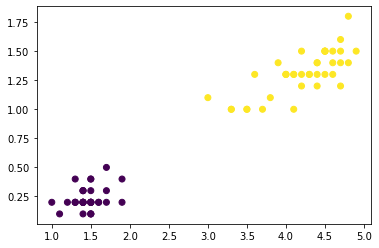

In [12]:
plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

In [13]:
iris_2label = iris.set_index("Name").loc[["Iris-virginica", "Iris-versicolor"]].reset_index()
iris_2d = iris_2label.iloc[:, -3:]
X_2d = iris_2d.iloc[:, :-1].values
y = iris_2d.iloc[:, -1].values
y[y == 2] = -1
X_train, X_test, y_train, y_test = train_test_split(X_2d, y, random_state=0)

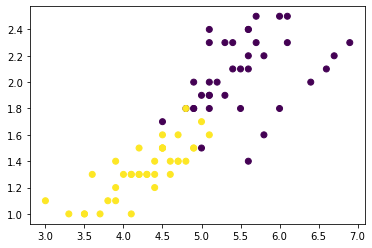

In [14]:
plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### svm test

In [15]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
svm = SVClassifier(C=100, learning_rate=0.001, gradient_type="stochastic").fit(X_train_scaled, y_train)

In [20]:
svm = SVClassifier(C=100, learning_rate=0.001, gradient_type="batch").fit(X_train_scaled, y_train)

In [21]:
svm.score(X_test_scaled, y_test)

0.96

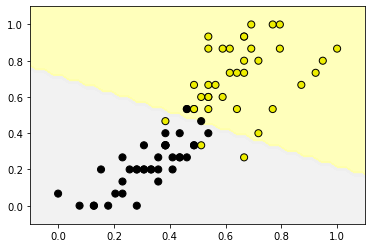

In [22]:
plot_classifier(svm, X_train_scaled, y_train)

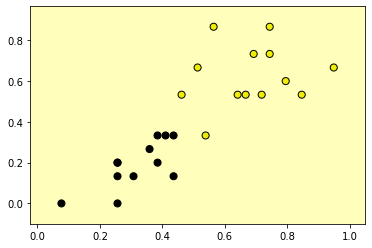

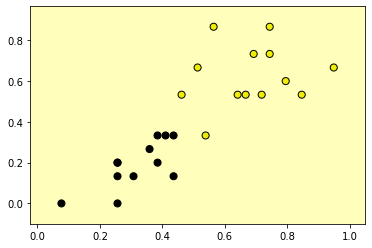

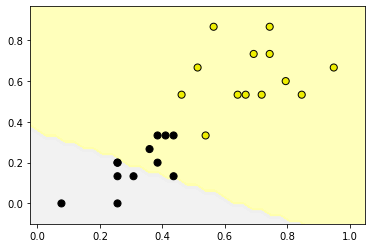

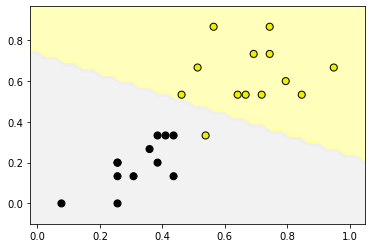

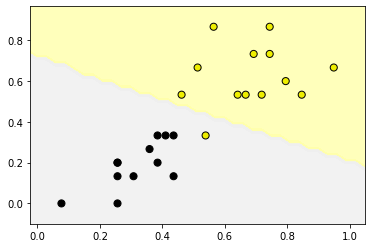

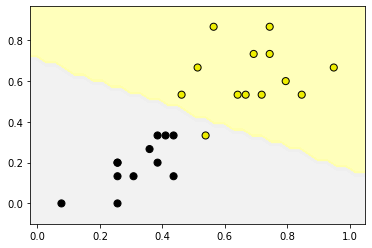

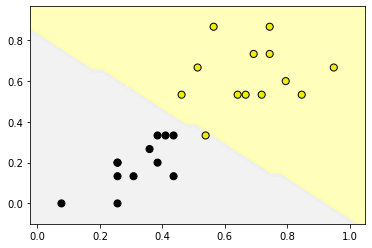

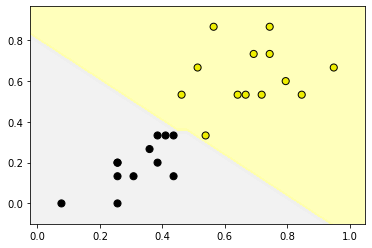

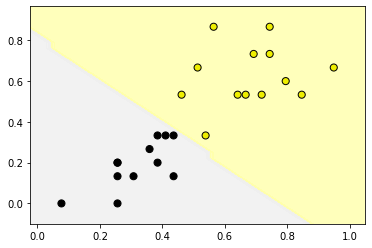

In [23]:
for c in [0.1, 1, 10, 50, 100, 1000, 10000, 100000, 1000000]:
    svm = SVClassifier(C=c, gradient_type="batch").fit(X_train_scaled, y_train)
    plot_classifier(svm, X_test_scaled, y_test)

In [54]:
for c in [1, 10, 100, 1000, 10000, 1000000, 100000000]:
    for rate in [0.001, 0.0001, 0.00001]:
        svm = SVClassifier(C=c, learning_rate=rate, gradient_type="stochastic").fit(X_train_scaled, y_train)
        score = svm.score(X_test_scaled, y_test)
        print("C: {}, rate: {}, score: {}".format(c, rate, score))

C: 1, rate: 0.001, score: 0.6
C: 1, rate: 0.0001, score: 1.0
C: 1, rate: 1e-05, score: 0.48
C: 10, rate: 0.001, score: 1.0
C: 10, rate: 0.0001, score: 0.88
C: 10, rate: 1e-05, score: 0.84
C: 100, rate: 0.001, score: 0.92
C: 100, rate: 0.0001, score: 0.96
C: 100, rate: 1e-05, score: 0.96
C: 1000, rate: 0.001, score: 0.96
C: 1000, rate: 0.0001, score: 0.96
C: 1000, rate: 1e-05, score: 0.96
C: 10000, rate: 0.001, score: 0.64
C: 10000, rate: 0.0001, score: 0.96
C: 10000, rate: 1e-05, score: 0.96
C: 1000000, rate: 0.001, score: 0.84
C: 1000000, rate: 0.0001, score: 0.96
C: 1000000, rate: 1e-05, score: 0.96
C: 100000000, rate: 0.001, score: 0.92
C: 100000000, rate: 0.0001, score: 1.0
C: 100000000, rate: 1e-05, score: 1.0


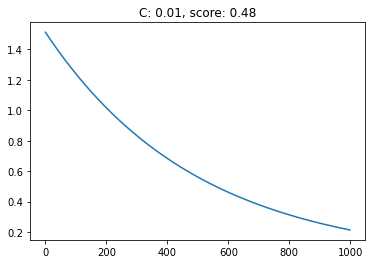

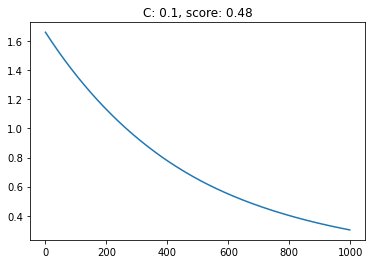

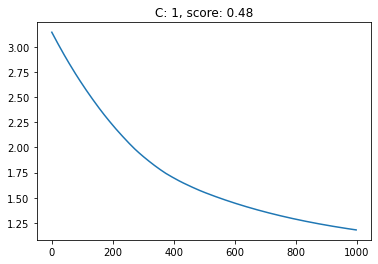

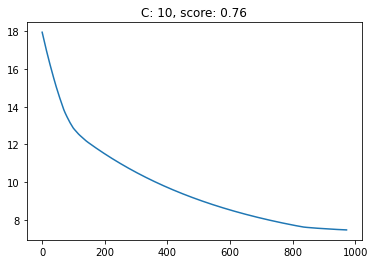

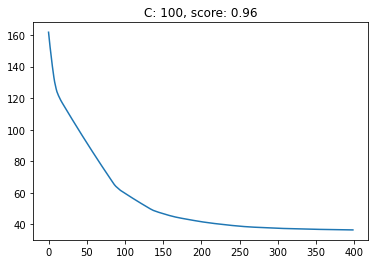

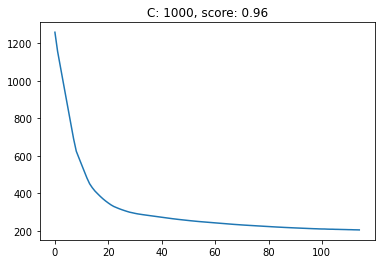

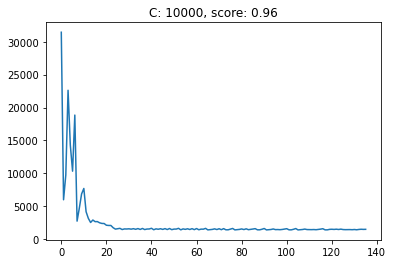

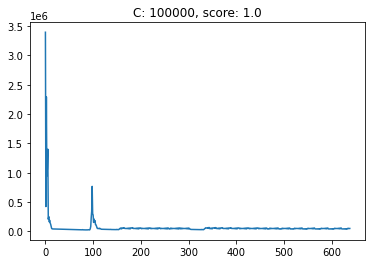

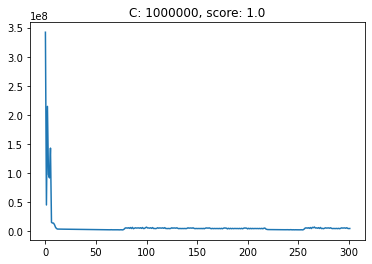

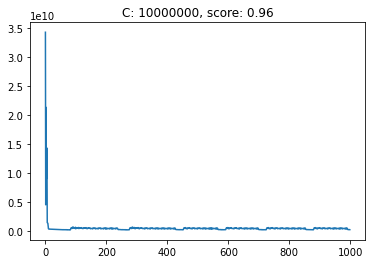

In [135]:
for c in [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]:
    svm = SVClassifier(C=c, gradient_type="batch").fit(X_train_scaled, y_train)
    score = svm.score(X_test_scaled, y_test)
    interval = range(0, len(svm.costs))
    plt.figure()
    plt.plot(interval, svm.costs)
    plt.title("C: {}, score: {}".format(c, score))

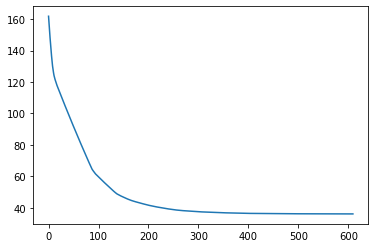

In [118]:
interval = range(0, len(svm.costs))
plt.plot(interval, svm.costs)

### svm gradient descent trial

In [172]:
# prepare data
X = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1)
y = y_train.copy()
    
max_iter = 1000
C = 100
learning_rate = 0.001
prev_cost = float("inf")
cost_thresh = 0.0001
w = np.zeros(X.shape[1])

for epoch in range(1, max_iter):
    # update weights
    ascent = calculate_cost_gradient(w, X, y)
    w = w - (learning_rate * ascent)
    #for i in range(len(X)):
        #ascent = calculate_cost_gradient(w, X[i], y[i])
    cost = calculate_cost(w, X, y)
    print("Epoch: {}, Cost: {}".format(epoch, cost))
    
    # stop
    #if np.mean(np.abs(ascent[1:])) < cost_thresh:
        #break
    if abs(prev_cost - cost) < cost_thresh * prev_cost:
        break
    prev_cost = cost

Epoch: 1, Cost: 76.31467525333333
Epoch: 2, Cost: 71.7067831063908
Epoch: 3, Cost: 66.28616030473891
Epoch: 4, Cost: 65.36648963613165
Epoch: 5, Cost: 64.62335128348413
Epoch: 6, Cost: 63.85153155932154
Epoch: 7, Cost: 63.16524342691817
Epoch: 8, Cost: 61.773418428801506
Epoch: 9, Cost: 60.92539017115879
Epoch: 10, Cost: 59.75437451054931
Epoch: 11, Cost: 58.96070918443885
Epoch: 12, Cost: 57.743344385244896
Epoch: 13, Cost: 57.003925367695956
Epoch: 14, Cost: 55.74029614626999
Epoch: 15, Cost: 55.055007079199356
Epoch: 16, Cost: 53.75324928521797
Epoch: 17, Cost: 52.89929321561964
Epoch: 18, Cost: 51.63177801584556
Epoch: 19, Cost: 50.76866494814643
Epoch: 20, Cost: 49.90769587022222
Epoch: 21, Cost: 49.01501365378492
Epoch: 22, Cost: 47.80660797130375
Epoch: 23, Cost: 46.899847920917296
Epoch: 24, Cost: 46.09288691531552
Epoch: 25, Cost: 45.16160246920117
Epoch: 26, Cost: 44.012039526620725
Epoch: 27, Cost: 43.06925995957658
Epoch: 28, Cost: 42.13866260826555
Epoch: 29, Cost: 41.1615

Epoch: 273, Cost: 5.260402031392471
Epoch: 274, Cost: 5.203850196605342
Epoch: 275, Cost: 5.254203280204242
Epoch: 276, Cost: 5.206810473116453
Epoch: 277, Cost: 5.248020149363292
Epoch: 278, Cost: 5.209768054623609
Epoch: 279, Cost: 5.241852594747728
Epoch: 280, Cost: 5.212722933643092
Epoch: 281, Cost: 5.235700572375373
Epoch: 282, Cost: 5.215675102757551
Epoch: 283, Cost: 5.229564038403274
Epoch: 284, Cost: 5.218624554615657
Epoch: 285, Cost: 5.2234429491272225
Epoch: 286, Cost: 5.221571281931782
Epoch: 287, Cost: 5.21733726098126
Epoch: 288, Cost: 5.2245152774856525
Epoch: 289, Cost: 5.2112469305372215
Epoch: 290, Cost: 5.227456534122018
Epoch: 291, Cost: 5.209453536917529
Epoch: 292, Cost: 5.2066093859638976
Epoch: 293, Cost: 5.203770920468022
Epoch: 294, Cost: 5.200938129064675
Epoch: 295, Cost: 5.212311648595105
Epoch: 296, Cost: 5.2228053677219775
Epoch: 297, Cost: 5.215277932640712
Epoch: 298, Cost: 5.216707877464067
Epoch: 299, Cost: 5.218241418122834
Epoch: 300, Cost: 5.2117

In [173]:
w

array([-2.46792585,  0.69687942,  1.02783169])

In [174]:
X = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)

In [175]:
np.sign(np.dot(X, w)) == y_test

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [176]:
y_test

array([-1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1,  1, -1,  1, -1], dtype=int64)

In [177]:
m = -w[1] / w[2]
b = -w[0] / w[2]

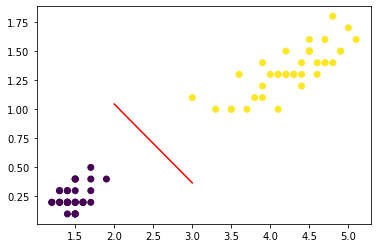

In [178]:
plt.figure()
interval = np.arange(2, 4)
line_y = m*interval + b
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.plot(interval, line_y, color="red")

In [40]:
svm = SVC(kernel="linear", C=1).fit(X_train, y_train)

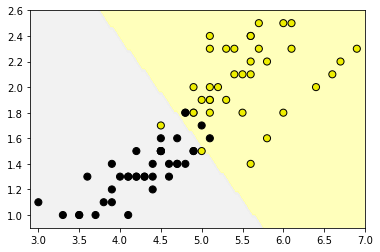

In [41]:
plot_classifier(svm, X_train, y_train)

In [98]:
svm.score(X_test, y_test)

1.0

In [99]:
svm.coef_

array([[-1.86153068, -2.20768712]])

In [100]:
svm.intercept_

array([12.68841789])

### synthetic classification

In [21]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                          n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1,
                          class_sep=2,flip_y=0,weights=[0.5,0.5], random_state=945)
y[y == 0] = -1

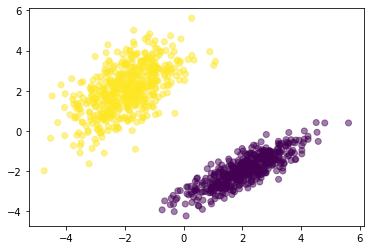

In [22]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [24]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# svm
svm = SVClassifier(C=1000).fit(X_train_scaled, y_train)
svm.score(X_test_scaled, y_test)

1.0

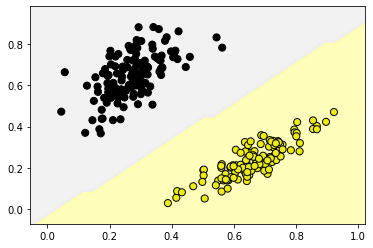

In [26]:
plot_classifier(svm, X_test_scaled, y_test)

In [27]:
svm = SVC(kernel="rbf").fit(X_train_scaled, y_train)

In [28]:
svm.score(X_test_scaled, y_test)

1.0

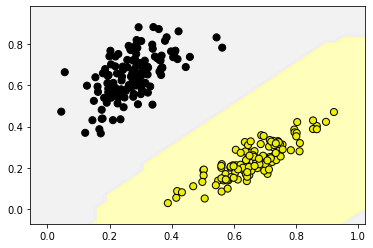

In [29]:
plot_classifier(svm, X_test_scaled, y_test)

C: 1, score: 0.504


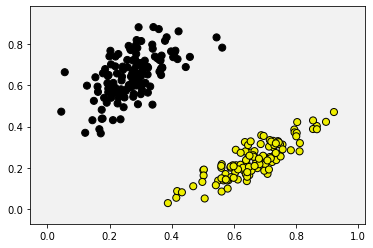

C: 10, score: 1.0


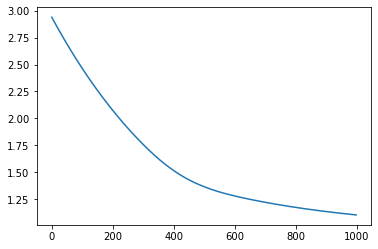

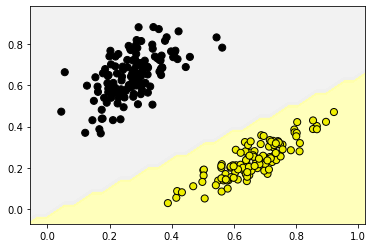

C: 100, score: 1.0


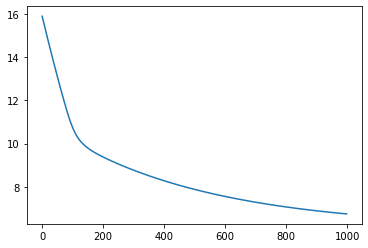

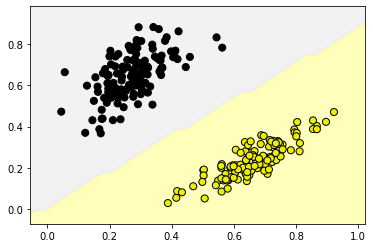

C: 1000, score: 1.0


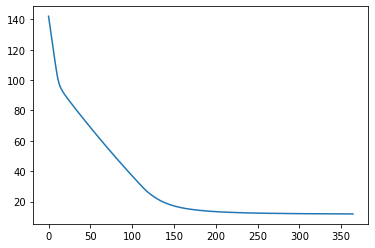

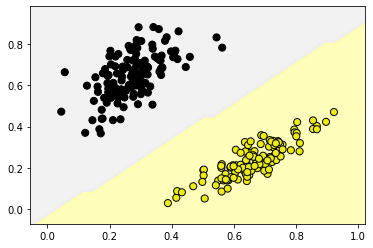

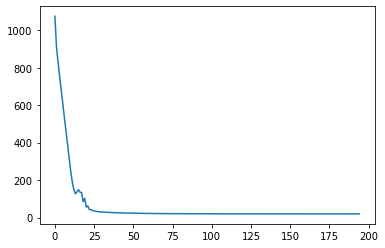

In [13]:
for c in [1, 10, 100, 1000]:
    svm = SVClassifier(C=c).fit(X_train_scaled, y_train)
    score = svm.score(X_test_scaled, y_test)
    print("C: {}, score: {}".format(c, score))
    plot_classifier(svm, X_test_scaled, y_test)
    
    plt.figure()
    interval = range(0, len(svm.costs))
    plt.plot(interval, svm.costs)

## more than 2d

In [30]:
X, y = make_classification(n_samples=5000, n_features=4, n_informative=4,
                          n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1,
                          class_sep=2,flip_y=0,weights=[0.5,0.5], random_state=24)
y[y == 0] = -1

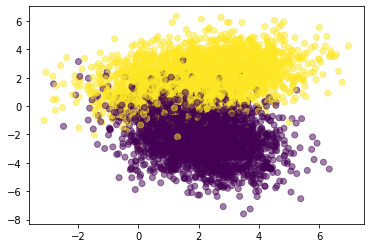

In [31]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
svm = SVClassifier(C=1000).fit(X_train_scaled, y_train)

In [36]:
svm.score(X_test_scaled, y_test)

1.0

### multiclass trial

In [27]:
X, y = make_classification(n_samples=2000, n_features=2, n_informative=2,
                          n_redundant=0, n_repeated=0, n_classes=3, n_clusters_per_class=1,
                          class_sep=2,flip_y=0,weights=[0.3,0.3,0.4], random_state=3943)

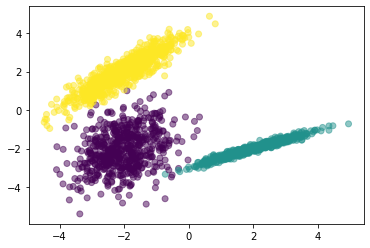

In [28]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [30]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
svm = SVClassifier(C=1000).fit(X_train_scaled, y_train)

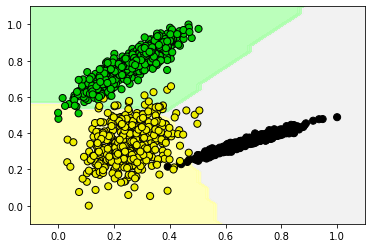

In [32]:
plot_classifier(svm, X_train_scaled, y_train)

In [33]:
svm.score(X_test_scaled, y_test)

0.966

### Save and Load test

In [34]:
# save
svm.save("svm1")

In [35]:
# load
svm2 = SVClassifier().load("svm1")

In [36]:
svm2.score(X_test_scaled, y_test)

0.966